In [1]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
import numpy as np
import tensorflow as tf
# import theano
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'

Using TensorFlow backend.


In [2]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(47)
#seting the seed for python random numbers
rn.seed(122)
#seting the seed for tensorflow random numbers
tf.set_random_seed(60)

In [3]:
train_path = '.\MAKEUP\Train' 
valid_path = '.\MAKEUP\Valid' 
#test_path = '.\CASIA1\Test' 


In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['MakeUp','Normal'], batch_size =8)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['MakeUp','Normal'], batch_size = 8)

Found 604 images belonging to 2 classes.
Found 154 images belonging to 2 classes.


In [5]:
# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()
        

In [6]:
imgs, labels = next(train_batches)

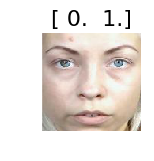

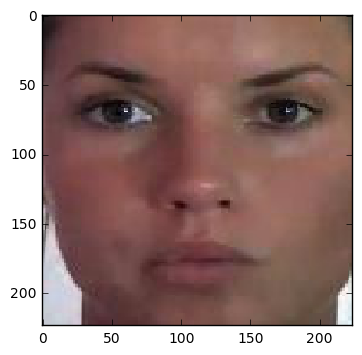

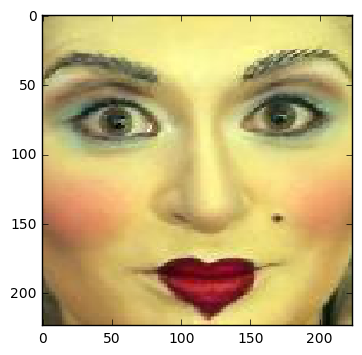

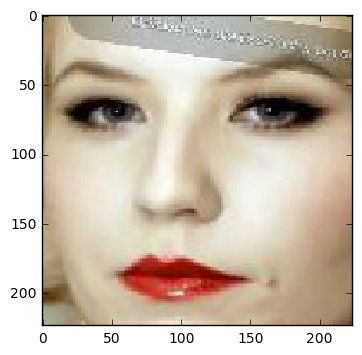

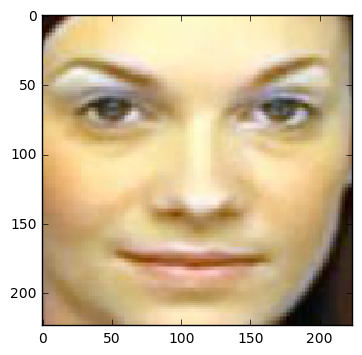

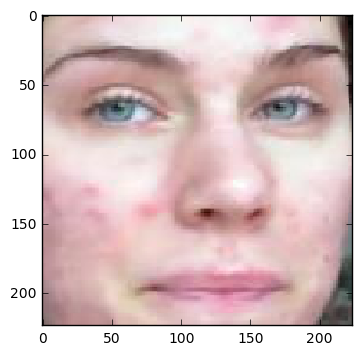

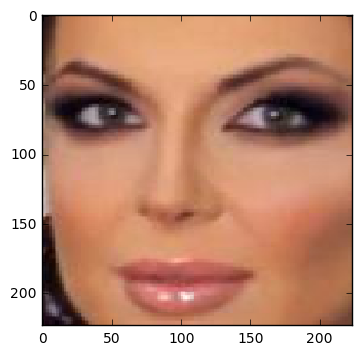

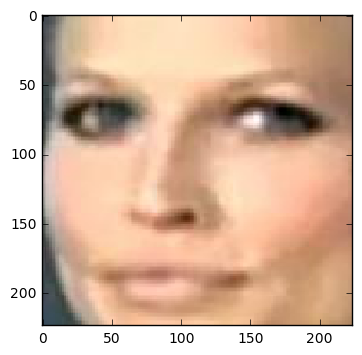

In [7]:
plots(imgs, titles = labels)

In [8]:
####  Build Fine-tuned VGG16 model
vgg19_model = keras.applications.vgg19.VGG19()
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
imgs, labels = next(train_batches)


In [10]:
model = Sequential()
for layer in vgg19_model.layers:
    model.add(layer)

In [11]:
model.layers.pop()


In [12]:
### add SVM in the  last layer
from keras import regularizers
model.add(Dense(2, activation = 'linear', kernel_regularizer=regularizers.l2(0.001)))
# model.add(Activation('linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
n = len(model.layers)
for idx, layer in enumerate(model.layers):
    if idx < (n-2): 
           layer.trainable = False   
    else:
           layer.trainable = True   
          

In [14]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

# model.compile(loss='hinge', optimizer='adadelta', metrics=['accuracy'])

# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='hinge', optimizer=sgd, metrics=['accuracy'])


In [15]:
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "weights19.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
history = model.fit_generator(train_batches, steps_per_epoch = 76, validation_data = valid_batches, validation_steps=26, epochs = 200, shuffle=True, callbacks = callbacks_list, verbose =2)


Epoch 1/200
 - 9s - loss: 0.9859 - acc: 0.5214 - val_loss: 0.9783 - val_acc: 0.5050

Epoch 00001: val_acc improved from -inf to 0.50495, saving model to weights19.best.hdf5
Epoch 2/200
 - 7s - loss: 0.9742 - acc: 0.5016 - val_loss: 0.9701 - val_acc: 0.4950

Epoch 00002: val_acc did not improve
Epoch 3/200
 - 7s - loss: 0.9660 - acc: 0.5000 - val_loss: 0.9616 - val_acc: 0.5099

Epoch 00003: val_acc improved from 0.50495 to 0.50990, saving model to weights19.best.hdf5
Epoch 4/200
 - 7s - loss: 0.9581 - acc: 0.4984 - val_loss: 0.9548 - val_acc: 0.4802

Epoch 00004: val_acc did not improve
Epoch 5/200
 - 7s - loss: 0.9503 - acc: 0.5016 - val_loss: 0.9454 - val_acc: 0.5347

Epoch 00005: val_acc improved from 0.50990 to 0.53465, saving model to weights19.best.hdf5
Epoch 6/200
 - 7s - loss: 0.9429 - acc: 0.4984 - val_loss: 0.9379 - val_acc: 0.5347

Epoch 00006: val_acc did not improve
Epoch 7/200
 - 7s - loss: 0.9354 - acc: 0.5000 - val_loss: 0.9313 - val_acc: 0.5099

Epoch 00007: val_acc did

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


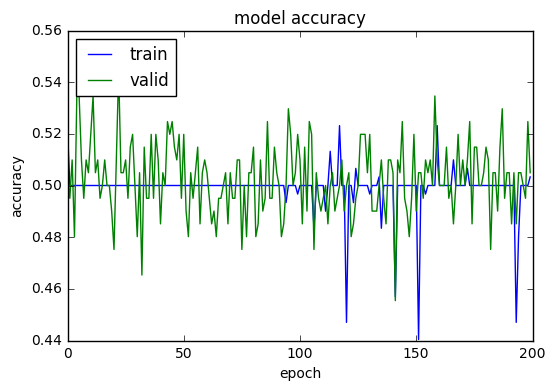

In [16]:

# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()

In [17]:
# Save model 
#model.save('forgecy_image_model.h5')
# model.summary()
# model.get_weights()
# model.optimizer
## Load  model 
#from keras.models import load_model 
#model = load_model('forgecy_image_model.h5')


In [18]:
# # estimate accuracy on whole dataset using loaded weights
# scores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [19]:
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:, 0]
predictions = model.predict_generator(test_batches, steps =1 , verbose = 0)
predictions
test_batches.class_indices
# rounded _predictions = model.predict_generator_classes(test_batches, steps =1 , verbose = 0)

NameError: name 'test_batches' is not defined

In [ ]:
cm = confusion_matrix(test_lables, np.round(predictions[:,0]))
cm_plot_labels = ['Au', 'Sp']
plot_confusion_matix(cm, cm_plot_labels, title = 'confusion Matrix')